# CS224W - Colab 5

本实验中我们将使用 `PyG`、`DeepSnap` 和 `NetworkX` 在加大规模的 GNN 上做实验。

首先我们使用 `PyG` 的 `NeighborSampler` 来提升在 `arxiv` 数据集上训练和测试的规模。

然后使用 `DeepSNAP` 和 `NetworkX` 实现了一个简化版本的 `NeighborSampler` 并在 `Cora` 图上以不同采样率进行了多次实验。

最终我们会使用不同的分割算法把 `Cora` 图分割成几个社群，然后使用原始 `Cluster-GCN` 的方式来训练模型。

**注意**：确保顺序执行所有代码单元，否则变量或库无法在之后的单元中使用。实验愉快 ：）

> 译者注：在原课程中，本次实验被取消了。因此本实验笔记是一个教程，不需要实现任何东西，以供参阅。后文提到实现函数其实都是实现好的。

In [1]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

## 1 `PyG` 的邻居采样

在邻居采样在 **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) 刚提出来时，它就是提升 GNN 规模的代表性的方法。正如 Lecture 中讲的，每次训练的时候，只有**K-跳**领域内的结点会被送到显卡中。为了进一步减少负担，我们可以在领域的结点中采样一个子集，以供 GNN 聚合。

### 配置

In [2]:
import copy
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborSampler
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

### 邻居采样器

`PyG` 已经实现了邻居采样的方法，具体为 `torch_geometric.loader` 中的 [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborSampler)。以下是一个在 OGB 数据集 `arxiv` 上使用邻居采样的示例。

如果你内存高效的聚合感兴趣，可以看看 `PyG` 的 [内存高效聚合(Memory-Efficient Aggregations)](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html)。

In [3]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Device: {device}')

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

# Construct the training dataloader for training data
# Sample 10 neighbors for each node in the first layer and 5 for the second layer
train_loader = NeighborSampler(data.adj_t, node_idx=train_idx,
                               sizes=[10, 5], batch_size=4096,
                               shuffle=True, num_workers=2)

# Specify size as -1 to include all neighbors
all_loader = NeighborSampler(data.adj_t, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=2)
evaluator = Evaluator(name='ogbn-arxiv')

Device: cuda


### GNN 模型

在创建了 `NeighborSampler` 之后，我们也可以修改模型以支持小批量训练。

模型的 `forward` 的参数有结点特征 `x`，一个列表的三元组 `adjs`。`adjs` 中每个三元组都有如下元素：

- `edge_index`: 描述源结点和目标结点之间的连通性的张量，可以组成一个二部图。
- `e_id`: 在原图中，边的索引。
- `size`: 二部图的形状，格式为（*源结点数量*，*目标结点数量*）。

In [4]:
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        for i in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        self.dropout = dropout

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adjs, mode="batch"):
        if mode == "batch":
            for i, (edge_index, _, size) in enumerate(adjs):
                # Extract target node features
                x_target = x[:size[1]]

                # Update x for next layer reuse
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        else:
            for i, conv in enumerate(self.convs):
                x = conv(x, adjs)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        return self.softmax(x)
    
    def inference(self, x_all, all_loader):
        # This function will be called in test
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in all_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
                
                # Append the node embeddings to xs
                xs.append(x.cpu())
            
            # Concat all embeddings into one tensor
            x_all = torch.cat(xs, dim=0)

        return x_all

### 训练和测试

现在我们来实现训练和测试函数。

在训练和测试中，我们都需要从 `dataloader` 中采样 `batch`。

`NeighborSampler` 的 `dataloader` 中每一个 `batch` 都有三个元素：

- `batch_size`: `dataloader` 中指定的 `batch` 的大小。
- `n_id`: 邻接矩阵中使用的所有结点（索引的形式）。
- `adjs`: 三元组。

In [5]:
def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch"):
    model.train()

    total_loss = 0
    if mode == "batch":
        for batch_size, n_id, adjs in train_loader:
            # Move all adj sparse tensors to GPU
            adjs = [adj.to(device) for adj in adjs]
            optimizer.zero_grad()

            # Index on the node features
            out = model(data.x[n_id], adjs)
            train_label = data.y[n_id[:batch_size]].squeeze(-1)
            loss = loss_fn(out, train_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    else:
        optimizer.zero_grad()
        out = model(data.x, data.adj_t, mode=mode)[train_idx]
        train_label = data.y.squeeze(1)[train_idx]
        loss = loss_fn(out, train_label)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

    return total_loss

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode="batch"):
    model.eval()

    if mode == "batch":
        out = model.inference(data.x, all_loader)
    else:
        out = model(data.x, data.adj_t, mode="all")

    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

### 小批量训练

In [6]:
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

batch_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
batch_model.reset_parameters()

optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_batch_model = None
best_valid_acc = 0

batch_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(batch_model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch")
    result = test(batch_model, data, all_loader, split_idx, evaluator, mode="batch")
    batch_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_batch_model = copy.deepcopy(batch_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_batch_model, data, all_loader, split_idx, evaluator, mode="batch")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 39.9949, Train: 61.98%, Valid: 64.29% Test: 64.58%
Epoch: 02, Loss: 28.6201, Train: 67.22%, Valid: 67.42% Test: 67.34%
Epoch: 03, Loss: 26.5773, Train: 68.86%, Valid: 68.58% Test: 67.77%
Epoch: 04, Loss: 25.5738, Train: 69.62%, Valid: 68.98% Test: 68.86%
Epoch: 05, Loss: 25.1625, Train: 70.58%, Valid: 69.31% Test: 68.04%
Epoch: 06, Loss: 24.5891, Train: 71.04%, Valid: 69.86% Test: 69.00%
Epoch: 07, Loss: 24.2960, Train: 71.55%, Valid: 69.76% Test: 68.51%
Epoch: 08, Loss: 24.0041, Train: 71.77%, Valid: 69.53% Test: 68.45%
Epoch: 09, Loss: 23.7737, Train: 71.68%, Valid: 69.46% Test: 68.10%
Epoch: 10, Loss: 23.4837, Train: 72.02%, Valid: 69.67% Test: 68.89%
Epoch: 11, Loss: 23.4279, Train: 72.45%, Valid: 69.98% Test: 68.50%
Epoch: 12, Loss: 23.2466, Train: 72.50%, Valid: 70.49% Test: 69.96%
Epoch: 13, Loss: 23.0562, Train: 73.01%, Valid: 69.98% Test: 68.04%
Epoch: 14, Loss: 22.9279, Train: 72.97%, Valid: 69.21% Test: 67.02%
Epoch: 15, Loss: 22.7103, Train: 73.23%, Valid: 

### 全批量训练

In [7]:
# Use the same parameters for a full-batch training
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

all_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
all_model.reset_parameters()

optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_all_model = None
best_valid_acc = 0

all_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(all_model, data, train_loader, train_idx, optimizer, loss_fn, mode="all")
    result = test(all_model, data, all_loader, split_idx, evaluator, mode="all")
    all_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_all_model = copy.deepcopy(all_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_all_model, data, all_loader, split_idx, evaluator, mode="all")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.9348, Train: 21.44%, Valid: 14.74% Test: 12.14%
Epoch: 02, Loss: 2.5788, Train: 29.83%, Valid: 33.18% Test: 31.83%
Epoch: 03, Loss: 2.2153, Train: 33.23%, Valid: 37.60% Test: 37.52%
Epoch: 04, Loss: 2.0321, Train: 36.22%, Valid: 42.42% Test: 43.86%
Epoch: 05, Loss: 1.9009, Train: 38.69%, Valid: 45.68% Test: 48.37%
Epoch: 06, Loss: 1.7901, Train: 40.92%, Valid: 47.55% Test: 50.58%
Epoch: 07, Loss: 1.7103, Train: 43.76%, Valid: 49.74% Test: 52.42%
Epoch: 08, Loss: 1.6431, Train: 46.59%, Valid: 52.40% Test: 54.00%
Epoch: 09, Loss: 1.5909, Train: 49.47%, Valid: 54.84% Test: 55.81%
Epoch: 10, Loss: 1.5427, Train: 52.62%, Valid: 57.20% Test: 57.93%
Epoch: 11, Loss: 1.4997, Train: 55.04%, Valid: 58.89% Test: 59.54%
Epoch: 12, Loss: 1.4614, Train: 56.59%, Valid: 59.88% Test: 60.31%
Epoch: 13, Loss: 1.4338, Train: 57.72%, Valid: 60.55% Test: 60.62%
Epoch: 14, Loss: 1.4078, Train: 58.62%, Valid: 61.14% Test: 61.00%
Epoch: 15, Loss: 1.3826, Train: 59.50%, Valid: 61.64% Test: 61

### 可视化

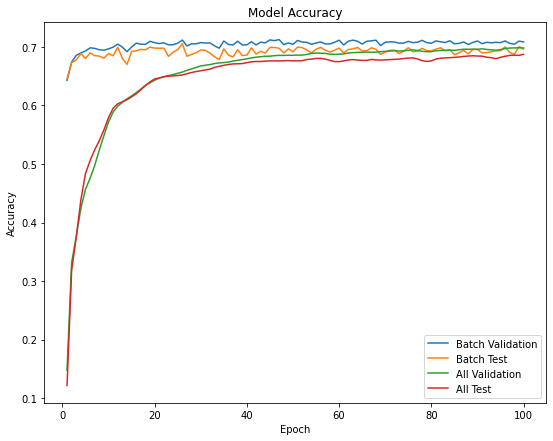

In [8]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_results)
all_results = np.array(all_results)

x = np.arange(1, 101)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 1], label="Batch Validation")
plt.plot(x, batch_results[:, 2], label="Batch Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 2 不同比率的邻居采样

现在我们使用 `DeepSNAP` 和 `NetworkX` 来实现一个简化版的邻居采样，并用不同比率的邻域采样来训练模型。

为了让实验进行的更快，我们这里使用 `Cora` 图。

### 配置

In [9]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./dataset', "Cora")

### GNN 模型

In [10]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="batch"):
        if mode == "batch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

### 邻居采样

我们使用 `DeepSNAP` 和 `NetworkX` 实现了能够采样邻居的函数。

注意 `Cora` 上的结点分类任务是一个半监督的分类任务，我们这里通过将最后的比率设为 1 来保留所有带标签的结点。

In [11]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # This fuction takes a set of nodes, a NetworkX graph G and neighbor sampling ratio.
    # It will return sampled neighbors (unioned with input nodes) and edges between 
    neighbors = set()
    edges = []
    for node in nodes:
        neighbors_list = list(nx.neighbors(G, node))

        # We only sample the (ratio * number of neighbors) neighbors
        num = int(len(neighbors_list) * ratio)
        if num > 0:
            # Random shuffle the neighbors
            random.shuffle(neighbors_list)
            neighbors_list = neighbors_list[:num]
            for neighbor in neighbors_list:
                # Add neighbors
                neighbors.add(neighbor)
                edges.append((neighbor, node))
    return neighbors, neighbors.union(all_nodes), edges

def nodes_to_tensor(nodes):
    # This function transform a set of nodes to node index tensor
    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index

def edges_to_tensor(edges):
    # This function transform a set of edges to edge index tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)
    return edge_index

def relable(nodes, labeled_nodes, edges_list):
    # Relable the nodes, labeled_nodes and edges_list
    relabled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]
    return relabled_edges_list, relabeled_nodes, relabeled_labeled_nodes

def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # This function takes a DeepSNAP graph, K the number of GNN layers, and neighbor 
    # sampling ratios for each layer. This function returns relabeled node feature, 
    # edge indices and node_label_index

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes
    for k in range(K):
        # Get nodes and edges from the previous layer
        nodes, all_nodes, edges = \
            sample_neighbors(nodes_list[-1], graph.G, ratios[len(ratios) - k - 2], all_nodes)
        nodes_list.append(nodes)
        edges_list.append(edges)
    
    # Reverse the lists
    nodes_list.reverse()
    edges_list.reverse()

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relable(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    print(f"Sampled {node_feature.shape[0]} nodes, {edge_indices[0].shape[1] // 2} edges, {node_label_index.shape[0]} labeled nodes")
    return node_feature, edge_indices, node_label_index

### 训练和测试

In [12]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[node_label_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model):
    model.eval()
    accs = []
    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)
    return accs

In [13]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

### 全批量训练

In [14]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Epoch: 01, Loss: 2.1188, Train: 30.71%, Valid: 17.20% Test: 15.22%
Epoch: 02, Loss: 1.2622, Train: 74.29%, Valid: 21.60% Test: 20.82%
Epoch: 03, Loss: 0.7614, Train: 97.14%, Valid: 46.00% Test: 34.13%
Epoch: 04, Loss: 0.4274, Train: 99.29%, Valid: 59.00% Test: 42.04%
Epoch: 05, Loss: 0.2153, Train: 100.00%, Valid: 64.20% Test: 45.95%
Epoch: 06, Loss: 0.1059, Train: 100.00%, Valid: 68.80% Test: 47.85%
Epoch: 07, Loss: 0.0706, Train: 100.00%, Valid: 68.60% Test: 48.45%
Epoch: 08, Loss: 0.0298, Train: 100.00%, Valid: 69.40% Test: 48.65%
Epoch: 09, Loss: 0.0178, Train: 100.00%, Valid: 69.40% Test: 48.55%
Epoch: 10, Loss: 0.0124, Train: 100.00%, Valid: 70.40% Test: 48.45%
Epoch: 11, Loss: 0.0105, Train: 100.00%, Valid: 70.80% Test: 48.35%
Epoch: 12, Loss: 0.0069, Train: 100.00%, Valid: 71.00% Test: 48.25%
Epoch: 13, Loss: 0.0055, Train: 100.00%, Valid: 71.20% Test: 48.25%
Epoch: 14, Loss: 0.00

### 采样率为 0.8

In [15]:
args['ratios'] = (0.8, 0.8, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Sampled 1318 nodes, 1998 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0422, Train: 24.29%, Valid: 9.20% Test: 9.01%
Sampled 1320 nodes, 1981 edges, 140 labeled nodes
Epoch: 02, Loss: 1.6583, Train: 52.14%, Valid: 17.60% Test: 16.62%
Sampled 1322 nodes, 1990 edges, 140 labeled nodes
Epoch: 03, Loss: 1.3578, Train: 74.29%, Valid: 22.20% Test: 22.32%
Sampled 1283 nodes, 1957 edges, 140 labeled nodes
Epoch: 04, Loss: 1.1184, Train: 85.71%, Valid: 26.80% Test: 28.33%
Sampled 1317 nodes, 1986 edges, 140 labeled nodes
Epoch: 05, Loss: 0.8693, Train: 92.86%, Valid: 30.40% Test: 31.53%
Sampled 1326 nodes, 2017 edges, 140 labeled nodes
Epoch: 06, Loss: 0.6834, Train: 94.29%, Valid: 33.80% Test: 35.44%
Sampled 1327 nodes, 2039 edges, 140 labeled nodes
Epoch: 07, Loss: 0.5296, Train: 95.00%, Valid: 37.00% Test: 37.54%
Sampled 1312 nodes, 1982 edges, 140 labeled nodes
Epoch: 08, Loss: 0.3911, Train: 95

### 采样率为 0.3

In [16]:
# Change the ratio to 0.3
args['ratios'] = (0.3, 0.3, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Sampled 432 nodes, 248 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0390, Train: 15.71%, Valid: 16.20% Test: 14.81%
Sampled 421 nodes, 242 edges, 140 labeled nodes
Epoch: 02, Loss: 1.9676, Train: 15.71%, Valid: 16.20% Test: 15.32%
Sampled 382 nodes, 188 edges, 140 labeled nodes
Epoch: 03, Loss: 1.8985, Train: 22.14%, Valid: 15.20% Test: 15.42%
Sampled 426 nodes, 236 edges, 140 labeled nodes
Epoch: 04, Loss: 1.8840, Train: 28.57%, Valid: 16.20% Test: 16.52%
Sampled 421 nodes, 251 edges, 140 labeled nodes
Epoch: 05, Loss: 1.8879, Train: 33.57%, Valid: 15.60% Test: 17.12%
Sampled 449 nodes, 264 edges, 140 labeled nodes
Epoch: 06, Loss: 1.7745, Train: 37.14%, Valid: 15.20% Test: 17.92%
Sampled 449 nodes, 256 edges, 140 labeled nodes
Epoch: 07, Loss: 1.7801, Train: 37.86%, Valid: 15.80% Test: 18.92%
Sampled 397 nodes, 217 edges, 140 labeled nodes
Epoch: 08, Loss: 1.7612, Train: 37.14%, Valid: 1

### 可视化

下面所有的准确度都是在全批量模式下评估的。

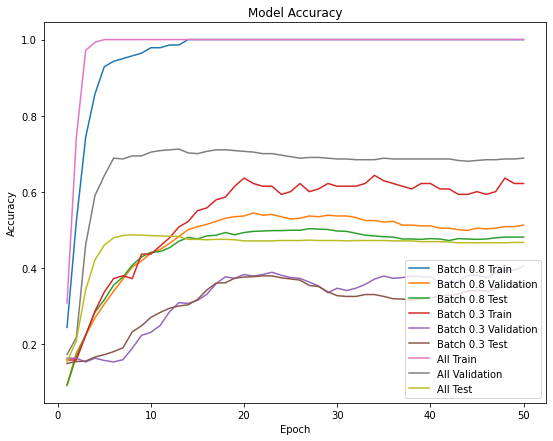

In [17]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_accs)
batch_results_1 = np.array(batch_accs_1)
all_results = np.array(all_accs)

x = np.arange(1, 51)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
plt.plot(x, batch_results_1[:, 0], label="Batch 0.3 Train")
plt.plot(x, batch_results_1[:, 1], label="Batch 0.3 Validation")
plt.plot(x, batch_results_1[:, 2], label="Batch 0.3 Test")
plt.plot(x, all_results[:, 0], label="All Train")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 3 聚簇采样

除了邻居采样，我们还可以用另一种方式来提升 GNN 的规模，即子图（聚簇）采样。这个方法是在 **Cluster-GCN**（[Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)）中提出的。

本小节中，我们会实现原始 **Cluster-GCN** 并在其上使用三个社群分割算法进行实验。

### 配置

In [18]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import community as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./dataset', "Cora")

In [19]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

### 将图分割成簇

现在我们使用三个社群检测/分割算法来将图分成不同的簇：

- [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
- [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
- [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)

为了让训练更稳定，我们丢弃了结点少于 10 个的簇。

现在将这些算法定义成 `DeepSNAP` 在图上的变换。

In [20]:
def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    if method == "louvain":
        community_mapping = community_louvain.best_partition(G, resolution=10)
        communities = {}
        for node in community_mapping:
            comm = community_mapping[node]
            if comm in communities:
                communities[comm].add(node)
            else:
                communities[comm] = set([node])
        communities = communities.values()
    elif method == "bisection":
        communities = nx.algorithms.community.kernighan_lin_bisection(G)
    elif method == "greedy":
        communities = nx.algorithms.community.greedy_modularity_communities(G)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

### Louvain 处理

In [21]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
print(f"Partition the graph in to {len(graphs)} communities")
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print(f"Each community has {avg_num_nodes} nodes in average")
print(f"Each community has {avg_num_edges} edges in average")

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Partition the graph in to 5 communities
Each community has 497 nodes in average
Each community has 963 edges in average


### Louvain 训练

In [22]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.3383, Train: 15.71%, Valid: 16.00% Test: 14.11%
Epoch: 02, Loss: 0.9373, Train: 15.00%, Valid: 6.00% Test: 6.51%
Epoch: 03, Loss: 3.1008, Train: 14.29%, Valid: 5.80% Test: 6.41%
Epoch: 04, Loss: 2.6769, Train: 14.29%, Valid: 5.80% Test: 6.41%
Epoch: 05, Loss: 1.2581, Train: 14.29%, Valid: 5.60% Test: 6.41%
Epoch: 06, Loss: 2.5007, Train: 15.71%, Valid: 4.60% Test: 6.11%
Epoch: 07, Loss: 0.1364, Train: 17.14%, Valid: 4.80% Test: 6.11%
Epoch: 08, Loss: 0.1902, Train: 16.43%, Valid: 4.80% Test: 5.81%
Epoch: 09, Loss: 1.6787, Train: 17.86%, Valid: 4.80% Test: 5.91%
Epoch: 10, Loss: 0.0706, Train: 17.14%, Valid: 4.80% Test: 5.81%
Epoch: 11, Loss: 1.1566, Train: 20.00%, Valid: 4.80% Test: 5.81%
Epoch: 12, Loss: 0.0017, Train: 28.57%, Valid: 5.00% Test: 6.01%
Epoch: 13, Loss: 0.0071, Train: 41.43%, Valid: 5.80% Test: 6.51%
Epoch: 14, Loss: 0.7173, Train: 45.71%, Valid: 8.00% Test: 7.31%
Epoch: 15, Loss: 0.1134, Train: 42.14%, Valid: 7.80% Test: 7.21%
Epoch: 16, Loss: 1.5073

### Bisection 处理

In [23]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
print(f"Partition the graph in to {len(graphs)} communities")
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print(f"Each community has {avg_num_nodes} nodes in average")
print(f"Each community has {avg_num_edges} edges in average")

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Partition the graph in to 2 communities
Each community has 1354 nodes in average
Each community has 2398 edges in average


### Bisection 训练

In [24]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 1.9904, Train: 32.86%, Valid: 16.80% Test: 15.02%
Epoch: 02, Loss: 0.9615, Train: 45.00%, Valid: 21.80% Test: 17.42%
Epoch: 03, Loss: 2.2506, Train: 57.14%, Valid: 31.40% Test: 23.92%
Epoch: 04, Loss: 1.5790, Train: 82.14%, Valid: 44.00% Test: 32.03%
Epoch: 05, Loss: 1.0196, Train: 97.86%, Valid: 55.20% Test: 38.44%
Epoch: 06, Loss: 0.6774, Train: 100.00%, Valid: 59.60% Test: 41.14%
Epoch: 07, Loss: 0.2584, Train: 100.00%, Valid: 62.20% Test: 40.74%
Epoch: 08, Loss: 0.2518, Train: 100.00%, Valid: 63.00% Test: 40.94%
Epoch: 09, Loss: 0.1797, Train: 100.00%, Valid: 63.00% Test: 40.74%
Epoch: 10, Loss: 0.1083, Train: 100.00%, Valid: 64.20% Test: 42.14%
Epoch: 11, Loss: 0.1409, Train: 100.00%, Valid: 65.00% Test: 42.24%
Epoch: 12, Loss: 0.0474, Train: 100.00%, Valid: 66.00% Test: 42.44%
Epoch: 13, Loss: 0.0421, Train: 100.00%, Valid: 66.20% Test: 43.14%
Epoch: 14, Loss: 0.0435, Train: 100.00%, Valid: 66.00% Test: 43.74%
Epoch: 15, Loss: 0.0512, Train: 100.00%, Valid: 67.40

### Greedy 处理

In [25]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
print(f"Partition the graph in to {len(graphs)} communities")
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print(f"Each community has {avg_num_nodes} nodes in average")
print(f"Each community has {avg_num_edges} edges in average")

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Partition the graph in to 20 communities
Each community has 121 nodes in average
Each community has 222 edges in average


### Greedy 训练

In [26]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.1392, Train: 14.29%, Valid: 12.20% Test: 13.01%
Epoch: 02, Loss: 2.2200, Train: 17.14%, Valid: 12.20% Test: 13.11%
Epoch: 03, Loss: 1.7456, Train: 12.86%, Valid: 22.40% Test: 26.13%
Epoch: 04, Loss: 1.8161, Train: 17.14%, Valid: 22.20% Test: 25.23%
Epoch: 05, Loss: 3.0355, Train: 18.57%, Valid: 19.40% Test: 25.43%
Epoch: 06, Loss: 2.7986, Train: 17.86%, Valid: 18.20% Test: 22.02%
Epoch: 07, Loss: 0.1227, Train: 22.14%, Valid: 16.40% Test: 22.82%
Epoch: 08, Loss: 2.1270, Train: 27.14%, Valid: 14.60% Test: 20.02%
Epoch: 09, Loss: 1.0236, Train: 25.00%, Valid: 10.00% Test: 13.81%
Epoch: 10, Loss: 1.6315, Train: 23.57%, Valid: 8.80% Test: 11.91%
Epoch: 11, Loss: 1.4013, Train: 27.14%, Valid: 9.00% Test: 12.61%
Epoch: 12, Loss: 3.8426, Train: 28.57%, Valid: 9.40% Test: 13.31%
Epoch: 13, Loss: 2.9519, Train: 30.00%, Valid: 9.20% Test: 14.01%
Epoch: 14, Loss: 3.0949, Train: 31.43%, Valid: 11.60% Test: 16.02%
Epoch: 15, Loss: 0.3820, Train: 32.86%, Valid: 13.00% Test: 18.12%

### 全批量训练

In [27]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Epoch: 01, Loss: 2.0796, Train: 49.29%, Valid: 18.20% Test: 13.61%
Epoch: 02, Loss: 1.2111, Train: 91.43%, Valid: 32.40% Test: 22.12%
Epoch: 03, Loss: 0.7033, Train: 99.29%, Valid: 46.80% Test: 33.53%
Epoch: 04, Loss: 0.3624, Train: 100.00%, Valid: 57.40% Test: 41.44%
Epoch: 05, Loss: 0.2360, Train: 100.00%, Valid: 63.20% Test: 44.44%
Epoch: 06, Loss: 0.1117, Train: 100.00%, Valid: 65.80% Test: 45.75%
Epoch: 07, Loss: 0.0497, Train: 100.00%, Valid: 66.80% Test: 46.35%
Epoch: 08, Loss: 0.0270, Train: 100.00%, Valid: 67.80% Test: 46.55%
Epoch: 09, Loss: 0.0177, Train: 100.00%, Valid: 68.60% Test: 47.25%
Epoch: 10, Loss: 0.0129, Train: 100.00%, Valid: 69.40% Test: 47.05%
Epoch: 11, Loss: 0.0069, Train: 100.00%, Valid: 69.20% Test: 47.25%
Epoch: 12, Loss: 0.0064, Train: 100.00%, Valid: 69.40% Test: 46.95%
Epoch: 13, Loss: 0.0022, Train: 100.00%, Valid: 69.60% Test: 47.05%
Epoch: 14, Loss: 0.0

### 可视化

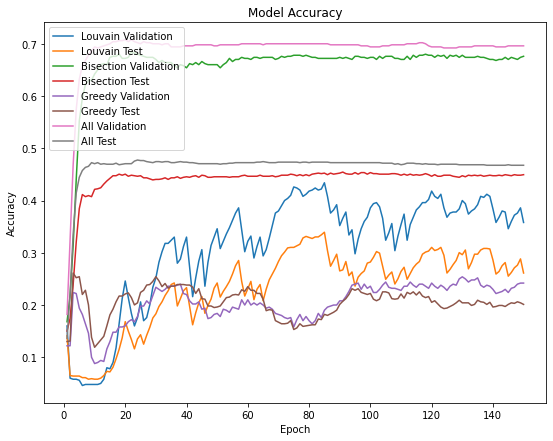

In [28]:
import numpy as np
from matplotlib import pyplot as plt

louvain_results = np.array(louvain_accs)
bisection_results = np.array(bisection_accs)
greedy_results = np.array(greedy_accs)
all_results = np.array(all_accs)

x = np.arange(1, 151)

plt.figure(figsize=(9, 7))

plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
plt.plot(x, louvain_results[:, 2], label="Louvain Test")
plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
plt.plot(x, bisection_results[:, 2], label="Bisection Test")
plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
plt.plot(x, greedy_results[:, 2], label="Greedy Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()